## Core Idea

Despite a lot of creeping Physics and Chemistry knowledge introduced in the description, this competition is more about Geometry and pattern matching.

The hypothesis of this kernel is next:
1. If we have two similar sets of atoms with the same distances between them and the same types - the scalar coupling constant should be very close.
2. More closest atoms to the pair of atoms under prediction have higher influence on scalar coupling constant then those with higher distance

So, basically, this problem could be dealt with some kind of K-Nearest Neighbor algorithm or any tree-based - e.g. LightGBM, in case we can find some representation which would describe similar configurations with similar feature sets.

Each atom is described with 3 cartesian coordinates. This representation is not stable. Each coupling pair is located in a different point in space and two similar coupling sets would have very different X,Y,Z.

So, instead of using coordinates let's consider next system:
1. Take each pair of atoms as two first core atoms
2. Calculate the center between the pair
3. Find all n-nearest atoms to the center (excluding first two atoms)
4. Take two closest atoms from step 3 - they will be 3rd and 4th core atoms
5. Calculate the distances from 4 core atoms to the rest of the atoms and to the core atoms as well

Using this representation each atom position can be described by 4 distances from the core atoms. This representation is stable to rotation and translation. And it's suitable for pattern-matching. So, we can take a sequence of atoms, describe each by 4 distances + atom type(H,O,etc) and looking up for the same pattern we can find similar configurations and detect scalar coupling constant.

Here I used LightGBM, because sklearn KNN can't deal with the amount of data. My blind guess is that hand-crafted KNN can outperform LightGBM.

Let's code the solution!

## Load Everything

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import math
import gc
import copy

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMRegressor
import os
# os.listdir('../input/imputed')

In [2]:
DATA_PATH = '..\\input'
SUBMISSIONS_PATH = '..\\output'
# use atomic numbers to recode atomic names
ATOMIC_NUMBERS = {
    'H': 1,
    'C': 6,
    'N': 7,
    'O': 8,
    'F': 9
}

In [3]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)

## Load Dataset

By default all data is read as `float64` and `int64`. We can trade this uneeded precision for memory and higher prediction speed. So, let's read with Pandas all the data in the minimal representation: 

In [4]:
train_dtypes = {
    'molecule_name': 'category',
    'atom_index_0': 'int8',
    'atom_index_1': 'int8',
    'type': 'category',
    'scalar_coupling_constant': 'float32'
}
train_csv = pd.read_csv(f'{DATA_PATH}\\train.csv', index_col='id', dtype=train_dtypes)
train_csv['molecule_index'] = train_csv.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
train_csv = train_csv[['molecule_index', 'atom_index_0', 'atom_index_1', 'type', 'scalar_coupling_constant']]
train_csv.head(10)

C:\ProgramFiles\Anaconda\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,molecule_index,atom_index_0,atom_index_1,type,scalar_coupling_constant
id,,,,,
0,1,1,0,1JHC,84.807602
1,1,1,2,2JHH,-11.257000
2,1,1,3,2JHH,-11.254800
3,1,1,4,2JHH,-11.254300
4,1,2,0,1JHC,84.807404
5,1,2,3,2JHH,-11.254100
6,1,2,4,2JHH,-11.254800
7,1,3,0,1JHC,84.809303
8,1,3,4,2JHH,-11.254300


#### Filter

In [5]:
train_csv, _ = train_test_split(train_csv, test_size=0.9, random_state=42)

#### Train_CSV Params

In [6]:
train_csv.describe()

,molecule_index,atom_index_0,atom_index_1,scalar_coupling_constant
count,465814.000000,465814.000000,465814.000000,465814.000000
mean,69268.130563,13.358577,5.889037,15.912537
std,36611.492817,3.262254,4.998477,34.920429
min,1.000000,1.000000,0.000000,-33.582699
25%,39073.000000,11.000000,2.000000,-0.262648
50%,71760.000000,13.000000,5.000000,2.278085
75%,100919.000000,16.000000,8.000000,7.378878
max,133884.000000,28.000000,28.000000,203.188995


In [7]:
print('Shape: ', train_csv.shape)
print('Total: ', train_csv.memory_usage().sum())
train_csv.memory_usage()

Shape:  (465814, 5)
Total:  8850850


Index                       3726512
molecule_index              1863256
atom_index_0                465814 
atom_index_1                465814 
type                        466198 
scalar_coupling_constant    1863256
dtype: int64

In [8]:
submission_csv = pd.read_csv(f'{DATA_PATH}\\sample_submission.csv', index_col='id')

C:\ProgramFiles\Anaconda\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [9]:
test_csv = pd.read_csv(f'{DATA_PATH}\\test.csv', index_col='id', dtype=train_dtypes)
test_csv['molecule_index'] = test_csv['molecule_name'].str.replace('dsgdb9nsd_', '').astype('int32')
test_csv = test_csv[['molecule_index', 'atom_index_0', 'atom_index_1', 'type']]
test_csv.head(10)

,molecule_index,atom_index_0,atom_index_1,type
id,,,,
4658147,4,2,0,2JHC
4658148,4,2,1,1JHC
4658149,4,2,3,3JHH
4658150,4,3,0,1JHC
4658151,4,3,1,2JHC
4658152,15,3,0,1JHC
4658153,15,3,2,3JHC
4658154,15,3,4,2JHH
4658155,15,3,5,2JHH


In [10]:
structures_dtypes = {
    'molecule_name': 'category',
    'atom_index': 'int8',
    'atom': 'category',
    'x': 'float32',
    'y': 'float32',
    'z': 'float32'
}
structures_csv = pd.read_csv(f'{DATA_PATH}\\structures.csv', dtype=structures_dtypes)
structures_csv['molecule_index'] = structures_csv.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
structures_csv = structures_csv[['molecule_index', 'atom_index', 'atom', 'x', 'y', 'z']]
structures_csv['atom'] = structures_csv['atom'].replace(ATOMIC_NUMBERS).astype('int8')
structures_csv.head(10)

,molecule_index,atom_index,atom,x,y,z
0,1,0,6,-0.012698,1.085804,0.008001
1,1,1,1,0.002150,-0.006031,0.001976
2,1,2,1,1.011731,1.463751,0.000277
3,1,3,1,-0.540815,1.447527,-0.876644
4,1,4,1,-0.523814,1.437933,0.906397
5,2,0,7,-0.040426,1.024108,0.062564
6,2,1,1,0.017257,0.012545,-0.027377
7,2,2,1,0.915789,1.358745,-0.028758
8,2,3,1,-0.520278,1.343532,-0.775543
9,3,0,8,-0.034360,0.977540,0.007602


In [11]:
print('Shape: ', structures_csv.shape)
print('Total: ', structures_csv.memory_usage().sum())
structures_csv.memory_usage()

Shape:  (2358657, 6)
Total:  42455906


Index             80     
molecule_index    9434628
atom_index        2358657
atom              2358657
x                 9434628
y                 9434628
z                 9434628
dtype: int64

## Build Distance Dataset

### Functions

In [12]:
def build_type_dataframes(base, structures, coupling_type):
    base = base[base['type'] == coupling_type].drop('type', axis=1).copy()
    base = base.reset_index()
    base['id'] = base['id'].astype('int32')
    structures = structures[structures['molecule_index'].isin(base['molecule_index'])]
    return base, structures

In [13]:
def add_coordinates(base, structures, index):
    df = pd.merge(base, structures, how='inner',
                  left_on=['molecule_index', f'atom_index_{index}'],
                  right_on=['molecule_index', 'atom_index']).drop(['atom_index'], axis=1)
    df = df.rename(columns={
        'atom': f'atom_{index}',
        'x': f'x_{index}',
        'y': f'y_{index}',
        'z': f'z_{index}'
    })
    return df

In [14]:
def add_atoms(base, atoms):
    df = pd.merge(base, atoms, how='inner',
                  on=['molecule_index', 'atom_index_0', 'atom_index_1'])
    return df

In [15]:
def merge_all_atoms(base, structures):
    df = pd.merge(base, structures, how='left',
                  left_on=['molecule_index'],
                  right_on=['molecule_index'])
    df = df[(df.atom_index_0 != df.atom_index) & (df.atom_index_1 != df.atom_index)]
    return df

In [16]:
def add_center(df):
    df['x_c'] = ((df['x_1'] + df['x_0']) * np.float32(0.5))
    df['y_c'] = ((df['y_1'] + df['y_0']) * np.float32(0.5))
    df['z_c'] = ((df['z_1'] + df['z_0']) * np.float32(0.5))

def add_distance_to_center(df):
    df['d_c'] = ((
        (df['x_c'] - df['x'])**np.float32(2) +
        (df['y_c'] - df['y'])**np.float32(2) + 
        (df['z_c'] - df['z'])**np.float32(2)
    )**np.float32(0.5))

def add_distance_between(df, suffix1, suffix2):
    df[f'd_{suffix1}_{suffix2}'] = ((
        (df[f'x_{suffix1}'] - df[f'x_{suffix2}'])**np.float32(2) +
        (df[f'y_{suffix1}'] - df[f'y_{suffix2}'])**np.float32(2) + 
        (df[f'z_{suffix1}'] - df[f'z_{suffix2}'])**np.float32(2)
    )**np.float32(0.5))

In [17]:
def add_distances(df):
    n_atoms = 1 + max([int(c.split('_')[1]) for c in df.columns if c.startswith('x_')])
    
    for i in range(1, n_atoms):
        for vi in range(min(4, i)):
            add_distance_between(df, i, vi)

In [18]:
def add_n_atoms(base, structures):
    dfs = structures['molecule_index'].value_counts().rename('n_atoms').to_frame()
    return pd.merge(base, dfs, left_on='molecule_index', right_index=True)

In [19]:
def build_couple_dataframeOld(some_csv, structures_csv, coupling_type, n_atoms=10):
    base, structures = build_type_dataframes(some_csv, structures_csv, coupling_type)
    base = add_coordinates(base, structures, 0)
    base = add_coordinates(base, structures, 1)
    
    base = base.drop(['atom_0', 'atom_1'], axis=1)
    atoms = base.drop('id', axis=1).copy()
    if 'scalar_coupling_constant' in some_csv:
        atoms = atoms.drop(['scalar_coupling_constant'], axis=1)
        
    add_center(atoms)
    
    
    atoms = atoms.drop(['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1'], axis=1)

    atoms = merge_all_atoms(atoms, structures)
    
    add_distance_to_center(atoms)
    
    atoms = atoms.drop(['x_c', 'y_c', 'z_c', 'atom_index'], axis=1)
    atoms.sort_values(['molecule_index', 'atom_index_0', 'atom_index_1', 'd_c'], inplace=True)
    atom_groups = atoms.groupby(['molecule_index', 'atom_index_0', 'atom_index_1'])
    atoms['num'] = atom_groups.cumcount() + 2
    atoms = atoms.drop(['d_c'], axis=1)
    atoms = atoms[atoms['num'] < n_atoms]

    atoms = atoms.set_index(['molecule_index', 'atom_index_0', 'atom_index_1', 'num']).unstack()
    atoms.columns = [f'{col[0]}_{col[1]}' for col in atoms.columns]
    atoms = atoms.reset_index()
    
    # downcast back to int8
    for col in atoms.columns:
        if col.startswith('atom_'):
            atoms[col] = atoms[col].fillna(0).astype('int8')
            
    atoms['molecule_index'] = atoms['molecule_index'].astype('int32')
    
    full = add_atoms(base, atoms)
    add_distances(full)
    
    full.sort_values('id', inplace=True)
    
    return full

In [20]:
def take_n_atoms(df, n_atoms, four_start=4):
    labels = []
    for i in range(2, n_atoms):
        label = f'atom_{i}'
        labels.append(label)

    for i in range(n_atoms):
        num = min(i, 4) if i < four_start else 4
        for j in range(num):
            labels.append(f'd_{i}_{j}')
    if 'scalar_coupling_constant' in df:
        labels.append('scalar_coupling_constant')
    output = df[labels]
    atoms_names = list([col for col in output if col.startswith('atom_')])[2:]
    output = output.drop(atoms_names, axis=1)
    return output

In [21]:
def map_atom_info(df, atom_idx):
    structures = structures_csv[['molecule_index', 'atom_index', 'atom']]
    structures = structures_csv
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_index', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_index',  'atom_index'])
    df = df.rename(columns={'atom': f'atom_{atom_idx}'});
    #df = df.drop('atom_index', axis=1)    
    return df

### Проверяем, что для каждого типа молекулы только  atom_1 принимает только одно значение

In [22]:
invest0 = map_atom_info(train_csv, 1)
invest0 = invest0[['type','atom_1']]
invest0.groupby(['type']).mean()

,atom_1
type,
1JHC,6
1JHN,7
2JHC,6
2JHH,1
2JHN,7
3JHC,6
3JHH,1
3JHN,7


## Check Regressions for a simple type

In [23]:
def build_atoms(base_from, structures_from, n_atoms):
    base = base_from
    structures = structures_from

    atoms = base.drop('id', axis=1).copy()
    if 'scalar_coupling_constant' in atoms:
        atoms = atoms.drop(['scalar_coupling_constant'], axis=1)

    add_center(atoms)

    atoms = merge_all_atoms(atoms, structures)

    add_distance_to_center(atoms)

    atoms.sort_values(['molecule_index', 'atom_index_0', 'atom_index_1', 'd_c'], inplace=True)
    atom_groups = atoms.groupby(['molecule_index', 'atom_index_0', 'atom_index_1'])
    atoms['num'] = atom_groups.cumcount() + 2
    atoms = atoms.drop(['d_c'], axis=1)
    atoms = atoms[atoms['num'] < n_atoms]

    atoms = atoms.drop(['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1'], axis=1)
    #atoms = atoms.drop(['x_c', 'y_c', 'z_c', 'atom_index'], axis=1)
    atoms = atoms.drop(['atom_index'], axis=1)
    atoms = atoms.set_index(['molecule_index', 'atom_index_0', 'atom_index_1', 'x_c', 'y_c', 'z_c', 'num']).unstack()
    atoms.columns = [f'{col[0]}_{col[1]}' for col in atoms.columns]
    atoms = atoms.reset_index()

    # downcast back to int8
    for col in atoms.columns:
        if col.startswith('atom_'):
            atoms[col] = atoms[col].fillna(0).astype('int8')
            
    atoms['molecule_index'] = atoms['molecule_index'].astype('int32')
    
    return atoms

def build_coors(some_csv, structures_csv, coupling_type, n_atoms):
    base, structures = build_type_dataframes(some_csv, structures_csv, coupling_type)
    base = add_coordinates(base, structures, 0)
    base = add_coordinates(base, structures, 1)
    base = base.drop(['atom_0', 'atom_1'], axis=1)

    #def build_atoms(some_csv, base_from, structures_from, coupling_type, n_atoms):
    atoms = build_atoms(base, structures, n_atoms)
    full = add_atoms(base, atoms)
    return full

#distance along axis
def calc_dist_along(row, suffix = 1):
    coor_center = np.array([row['x_c'], row['y_c'], row['z_c']])
    coor_0 = np.array([row['x_0'], row['y_0'], row['z_0']])
    axis = coor_0 - coor_center
    axis = axis / np.linalg.norm(axis)
    
    
    coor_atom = np.array([row[f'x_{suffix}'], row[f'y_{suffix}'], row[f'z_{suffix}']])
    localCoor = coor_atom - coor_center
    distAlongAxis = 1 / np.dot(localCoor, axis)
    return distAlongAxis

#add distances along axis
def add_distances_along(df):
    filter_col = [col for col in df if col.startswith('x_')]
    n_atoms = len(filter_col) - 1
    #print(n_atoms)
    for i in range(1, n_atoms):
            print("i", i)
            df[f'dist_along_{i}'] = df.apply(calc_dist_along,  axis=1, args=[i])

def build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms=10):
    full = build_coors(some_csv, structures_csv, coupling_type, n_atoms)
    add_distances_along(full)
    full.sort_values('id', inplace=True)
    return full

molecule_index = 74142
some_csv = train_csv[train_csv.molecule_index == molecule_index]
coupling_type = '1JHC'
n_atoms = 4

full = build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms)
full

i 1
i 2
i 3


,id,molecule_index,atom_index_0,atom_index_1,scalar_coupling_constant,x_0,y_0,z_0,x_1,y_1,z_1,x_c,y_c,z_c,atom_2,atom_3,x_2,x_3,y_2,y_3,z_2,z_3,dist_along_1,dist_along_2,dist_along_3
1,2432665,74142,11,0,76.555702,-0.585271,1.934943,0.855228,-0.005262,1.522206,0.022571,-0.295267,1.728574,0.438900,1,1,-0.455262,1.016509,1.875459,1.905050,-0.90862,0.082239,-1.825682,-1.130997,-1.112188
0,2432671,74142,12,2,86.281502,-1.896480,-0.231816,-0.981697,-1.420979,-0.589530,-0.064809,-1.658729,-0.410673,-0.523253,1,1,-1.381680,-2.036727,-1.680933,-0.287259,-0.09426,0.787827,-1.829753,-1.115958,-1.117370


In [24]:
%%time
full = build_couple_dataframe(train_csv, structures_csv, '1JHC', n_atoms=10)
full.describe()

i 1
i 2
i 3
i 4
i 5
i 6
i 7
i 8
i 9
Wall time: 41.1 s


,id,molecule_index,atom_index_0,atom_index_1,scalar_coupling_constant,x_0,y_0,z_0,x_1,y_1,z_1,x_c,y_c,z_c,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,atom_9,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9,dist_along_1,dist_along_2,dist_along_3,dist_along_4,dist_along_5,dist_along_6,dist_along_7,dist_along_8,dist_along_9
count,7.098500e+04,70985.000000,70985.000000,70985.000000,70985.000000,70985.000000,70985.000000,70985.000000,70985.000000,70985.000000,70985.000000,70985.000000,70985.000000,70985.000000,70985.000000,70985.000000,70985.000000,70985.000000,70985.000000,70985.000000,70985.000000,70985.000000,70985.000000,70985.000000,70985.000000,70984.000000,70982.000000,70980.000000,70975.000000,70957.000000,70985.000000,70985.000000,70985.000000,70984.000000,70982.000000,70980.000000,70975.000000,70957.000000,70985.000000,70985.000000,70985.000000,70984.000000,70982.000000,70980.000000,70975.000000,70957.000000,70985.000000,70985.000000,70985.000000,70985.000000,70984.000000,70982.000000,70980.000000,70975.000000,70957.000000
mean,2.355904e+06,69834.009396,13.382067,3.347327,94.889793,0.086643,-0.187871,0.061884,0.099891,-0.198380,0.063677,0.093267,-0.193126,0.062781,2.566965,4.710685,5.779644,2.700148,3.564021,4.023132,4.108319,4.118532,0.118606,0.109530,0.092977,0.085419,0.104980,0.142645,0.147342,0.147856,-0.121044,-0.096198,-0.389526,-0.451103,-0.400290,-0.415244,-0.414871,-0.373211,0.077114,0.066579,0.046536,0.031216,0.042809,0.062395,0.061665,0.056810,-1.830030,-1.045035,-0.944524,-0.890221,-0.561114,-4.918537,-0.561500,-0.667821,-0.189827
std,1.357880e+06,36951.209278,3.317098,2.649347,18.175396,1.767689,2.149102,1.581873,1.449631,1.853058,1.234283,1.583288,1.986002,1.379405,2.619321,2.593918,1.322392,2.580308,2.781314,2.735545,2.735422,2.735851,1.686791,1.486388,1.322212,1.621497,1.575892,1.532904,1.541977,1.544570,2.068832,1.943007,1.626505,1.865688,1.816474,1.755826,1.746090,1.755556,1.506234,1.283746,1.089476,1.427561,1.384864,1.365568,1.393616,1.384504,0.011445,0.138883,0.156300,0.705872,169.571803,1072.249931,100.221480,41.097456,58.191342
min,4.000000e+00,1.000000,2.000000,0.000000,66.926399,-7.694791,-8.922908,-8.909428,-6.829140,-7.864674,-8.227976,-7.186884,-8.393791,-8.568702,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.476476,-7.367952,-7.735908,-7.476476,-7.650790,-7.428946,-6.890171,-7.700063,-8.166577,-8.294255,-7.824676,-9.254405,-7.643277,-7.508174,-7.847767,-8.432506,-8.495410,-8.371802,-6.888381,-7.986579,-7.034232,-7.576644,-6.245091,-6.596640,-1.884952,-1.260249,-1.192099,-100.178883,-1022.718396,-285449.691087,-17154.380259,-8627.375426,-5962.251796
25%,1.181799e+06,39384.000000,11.000000,1.000000,84.024902,-0.938173,-1.829882,-0.951221,-0.470976,-1.572354,-0.420147,-0.626053,-1.699527,-0.622527,1.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.851564,-0.781746,-0.250556,-0.977968,-0.942610,-0.856734,-0.842346,-0.826623,-1.705611,-1.596568,-1.386938,-1.604286,-1.515689,-1.529674,-1.645887,-1.638396,-0.921927,-0.748145,-0.208667,-0.915287,-0.920355,-0.911846,-0.921338,-0.887847,-1.834325,-1.138153,-1.111178,-0.936043,-1.710503,-1.561342,-1.337736,-0.968872,-0.807757
50%,2.366152e+06,72458.000000,13.000000,3.000000,88.204498,0.051888,-0.247057,0.019393,0.030805,-0.274809,0.010562,0.082629,-0.259328,0.014533,1.000000,6.000000,6.000000,1.000000,1.000000,6.000000,6.000000,6.000000,0.073947,0.051492,0.029343,0.097940,0.127147,0.180351,0.168204,0.114739,-0.153863,-0.231528,-0.155777,-0.499765,-0.495546,-0.506746,-0.492476,-0.445592,0.030777,0.017851,0.008196,-0.000430,0.011894,0.018813,0.013753,0.013735,-1.828120,-1.115771,-0.945387,-0.909053,-1.387184,-1.021581,-0.569017,-0.464923,-0.442848
75%,3.544586e+06,101899.000000,16.000000,6.000000,100.346001,1.195460,1.800857,1.030817,0.896170,1.457150,0.641659,1.038893,1.635803,0.771517,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000

We don't calculate distances for `d_0_x`, `d_1_1`, `d_2_2`, `d_2_3`, `d_3_3` because we already have them in later atoms(`d_0_1` == `d_1_0`) or they are equal to zeros(e.g. `d_1_1`, `d_2_2`).

In [25]:
def take_n_atomsO(df, n_atoms, four_start=4):
    labels = []
    for i in range(2, n_atoms):
        label = f'atom_{i}'
        labels.append(label)

    for i in range(n_atoms):
        num = min(i, 4) if i < four_start else 4
        for j in range(num):
            labels.append(f'd_{i}_{j}')
    if 'scalar_coupling_constant' in df:
        labels.append('scalar_coupling_constant')
    output = df[labels]
    atoms_names = list([col for col in output if col.startswith('atom_')])[2:]
    output = output.drop(atoms_names, axis=1)
    return output

def take_n_atoms(df, n_atoms, four_start=4):
    labels = []
    for i in range(2, n_atoms):
        label = f'atom_{i}'
        labels.append(label)

    for i in range(1, n_atoms):
            labels.append(f'dist_along_{i}')
    if 'scalar_coupling_constant' in df:
        labels.append('scalar_coupling_constant')
    output = df[labels]
    #atoms_names = list([col for col in output if col.startswith('atom_')])[2:]
    #output = output.drop(atoms_names, axis=1)
    return output

In [26]:
df = take_n_atoms(full, 6)
df.head()


,atom_2,atom_3,atom_4,atom_5,dist_along_1,dist_along_2,dist_along_3,dist_along_4,dist_along_5,scalar_coupling_constant
32662,1,1,1,0,-1.831583,-1.099010,-1.098947,-1.098928,NaN,84.807404
18352,1,1,6,1,-1.826538,-1.142271,-1.142228,-0.903549,-1.284071,83.548599
49151,1,1,8,1,-1.817617,-1.126280,-1.116170,-0.911977,-1.238001,87.632599
9014,1,1,6,1,-1.827052,-1.135580,-1.135571,-0.900058,-1.363263,80.704697
32039,6,6,6,1,-1.883356,-0.575489,-0.322621,-0.232218,-0.186281,201.884003


For experiments, full dataset can be built with higher number of atoms, and for building a training/validation sets we can trim them:

In [27]:
df = take_n_atoms(full, 6)

#inverse of distances
#filter_col = [col for col in df if col.startswith('d_')]
#df[filter_col] = 1 / (df[filter_col])
#df.head()

# LightGBM performs better with 0-s then with NaN-s
df = df.fillna(0)
df.columns

Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'dist_along_1', 'dist_along_2',
       'dist_along_3', 'dist_along_4', 'dist_along_5',
       'scalar_coupling_constant'],
      dtype='object')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025126ADDE10>,
      dtype=object)

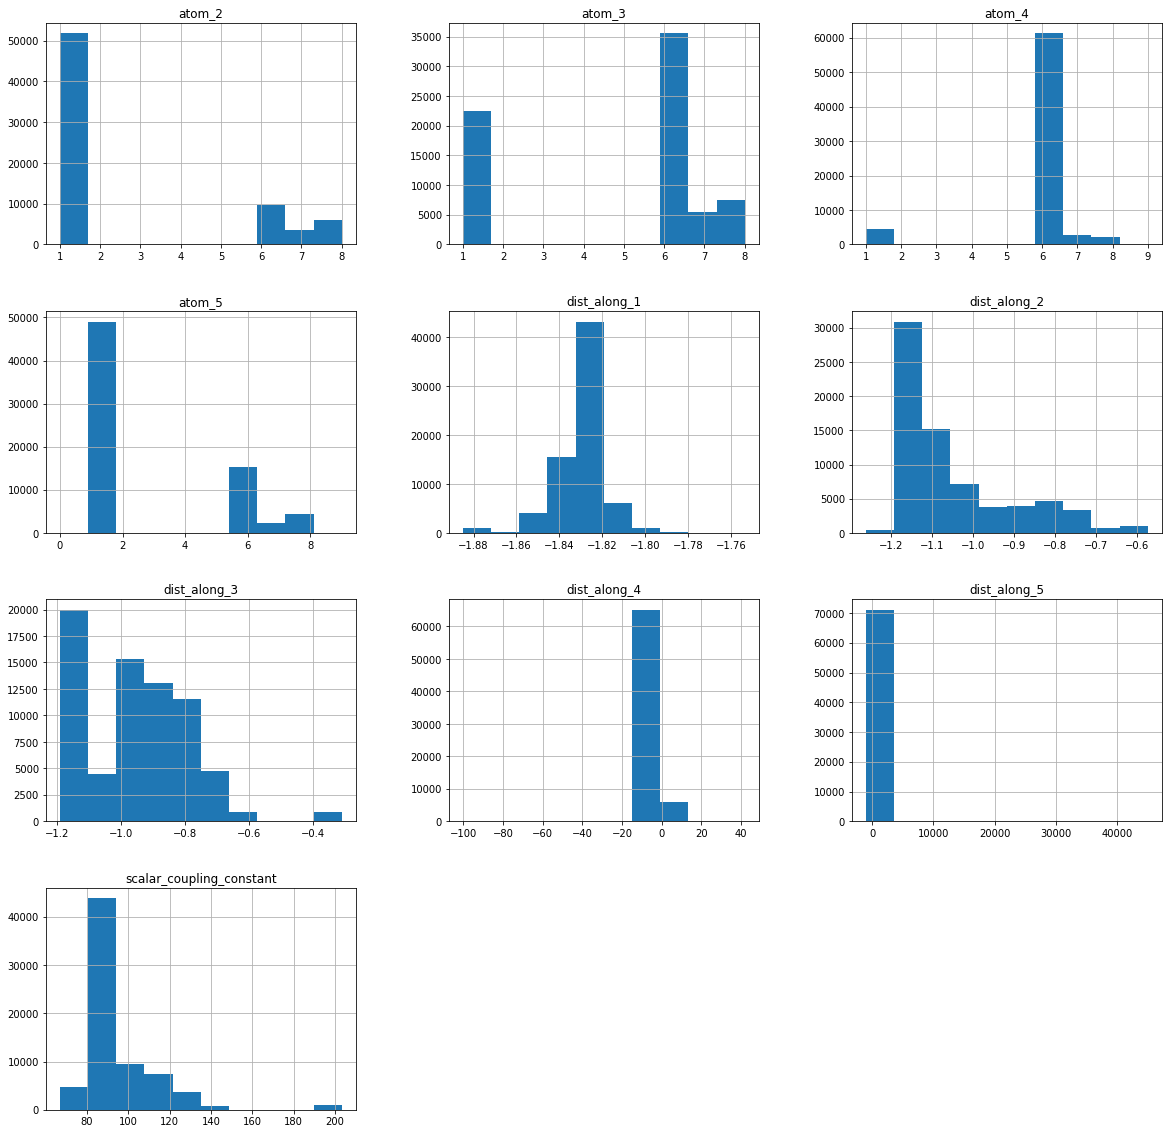

In [28]:
 df.hist(bins=10, figsize = [20,20] )

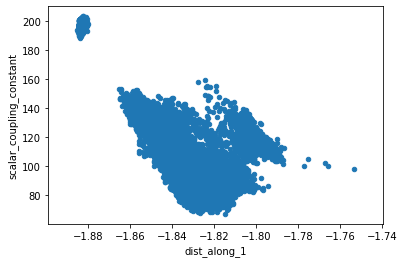

In [29]:
df.plot.scatter(x='dist_along_1', y = 'scalar_coupling_constant') 

In [30]:
#X_data = df.drop(['scalar_coupling_constant'], axis=1).values.astype('float32')
#y_data = df['scalar_coupling_constant'].values.astype('float32')
X_data = df.drop(['scalar_coupling_constant'], axis=1)
y_data = df['scalar_coupling_constant']


X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=128)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((56788, 9), (14197, 9), (56788,), (14197,))

## CatBoost

In [31]:
from catboost import CatBoostRegressor

In [32]:
CAT_PARAMS = {
          'learning_rate': 1,
           'max_depth': 3,    
           'n_estimators': 10
         }
#categorical features

categorical_features = [col for col in X_train if col.startswith('atom_')]
model = CatBoostRegressor(eval_metric='MAE', **CAT_PARAMS, loss_function='MAE')
model.fit(X_train, y_train, eval_set=((X_val, y_val)), 
          cat_features = categorical_features,
          use_best_model=True,
          verbose=True)

y_pred = model.predict(X_val)
np.log(mean_absolute_error(y_val, y_pred))

0:	learn: 94.4208156	test: 94.2687578	best: 94.2687578 (0)	total: 59.9ms	remaining: 539ms
1:	learn: 93.9209607	test: 93.7689248	best: 93.7689248 (1)	total: 70.6ms	remaining: 282ms
2:	learn: 93.4210926	test: 93.2690570	best: 93.2690570 (2)	total: 81.1ms	remaining: 189ms
3:	learn: 92.9213037	test: 92.7692673	best: 92.7692673 (3)	total: 89.6ms	remaining: 134ms
4:	learn: 92.4214603	test: 92.2694217	best: 92.2694217 (4)	total: 98.7ms	remaining: 98.7ms
5:	learn: 91.9216183	test: 91.7695729	best: 91.7695729 (5)	total: 107ms	remaining: 71.3ms
6:	learn: 91.4218292	test: 91.2697852	best: 91.2697852 (6)	total: 116ms	remaining: 49.6ms
7:	learn: 90.9220246	test: 90.7700151	best: 90.7700151 (7)	total: 124ms	remaining: 31ms
8:	learn: 90.4222357	test: 90.2702236	best: 90.2702236 (8)	total: 133ms	remaining: 14.7ms
9:	learn: 89.9223941	test: 89.7703818	best: 89.7703818 (9)	total: 141ms	remaining: 0us

bestTest = 89.7703818
bestIteration = 9



4.49725509688288

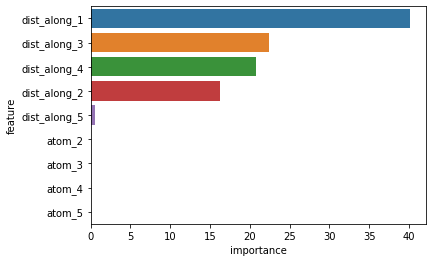

In [33]:
cols = list(X_train.columns)
#cols.remove('scalar_coupling_constant')
df_importance = pd.DataFrame({'feature': cols, 'importance': model.feature_importances_})
sns.barplot(x="importance", y="feature", data=df_importance.sort_values('importance', ascending=False));

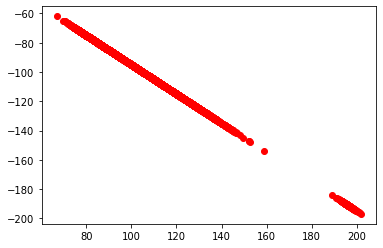

In [34]:
plt.plot(y_val, y_pred - y_val, 'ro')

## LGBMRegressor

In [35]:
#aaa

In [36]:
# configuration params are copied from @artgor kernel:
# https://www.kaggle.com/artgor/brute-force-feature-engineering
if False:
    LGB_PARAMS = {
        'objective': 'regression',
        'metric': 'mae',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': 0.2,
        'num_leaves': 128,
        'min_child_samples': 79,
        'max_depth': 9,
        'subsample_freq': 1,
        'subsample': 0.9,
        'bagging_seed': 11,
        'reg_alpha': 0.1,
        'reg_lambda': 0.3,
        'colsample_bytree': 1.0
    }
LGB_PARAMS = {
    'objective': 'regression',
    'metric': 'mae',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'learning_rate': 0.2,
    'num_leaves': 30,
    'min_child_samples': 79,
    'max_depth': 2,
    'subsample_freq': 1,
    'subsample': 0.9,
    'bagging_seed': 11,
    'reg_alpha': 0.1,
    'reg_lambda': 0.3,
    'colsample_bytree': 1.0
}

In [37]:
model = LGBMRegressor(**LGB_PARAMS, n_estimators=10000, n_jobs = -1)
model.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='mae',
        verbose=100, early_stopping_rounds=200)

y_pred = model.predict(X_val)
np.log(mean_absolute_error(y_val, y_pred))

Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 3.26642	valid_1's l1: 3.23206
[200]	training's l1: 3.05681	valid_1's l1: 3.03399
[300]	training's l1: 2.94451	valid_1's l1: 2.92833
[400]	training's l1: 2.85598	valid_1's l1: 2.84938
[500]	training's l1: 2.78404	valid_1's l1: 2.78282
[600]	training's l1: 2.73395	valid_1's l1: 2.73878
[700]	training's l1: 2.69577	valid_1's l1: 2.70495
[800]	training's l1: 2.66211	valid_1's l1: 2.67419
[900]	training's l1: 2.63481	valid_1's l1: 2.64981
[1000]	training's l1: 2.60548	valid_1's l1: 2.62289
[1100]	training's l1: 2.58202	valid_1's l1: 2.60063
[1200]	training's l1: 2.5634	valid_1's l1: 2.58526
[1300]	training's l1: 2.54495	valid_1's l1: 2.56976
[1400]	training's l1: 2.52897	valid_1's l1: 2.55723
[1500]	training's l1: 2.51229	valid_1's l1: 2.54511
[1600]	training's l1: 2.49787	valid_1's l1: 2.53214
[1700]	training's l1: 2.48436	valid_1's l1: 2.52071
[1800]	training's l1: 2.47132	valid_1's l1: 2.50953
[1900]	trai

0.8317479602270226

Not a bad score for such a simple set of features.

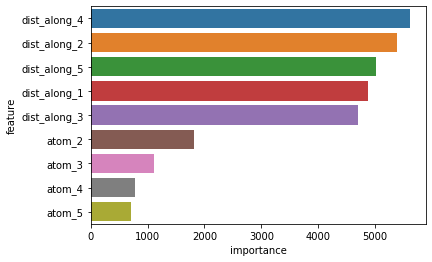

In [38]:
cols = list(df.columns)
cols.remove('scalar_coupling_constant')
cols
df_importance = pd.DataFrame({'feature': cols, 'importance': model.feature_importances_})
sns.barplot(x="importance", y="feature", data=df_importance.sort_values('importance', ascending=False));

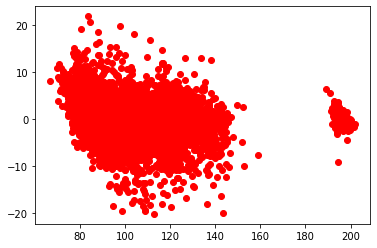

In [39]:
plt.plot(y_val, y_pred- y_val, 'ro')

It's funny, but looks like atom types aren't used a lot in the final decision. Quite a contrary to what a man would do.

## Submission Model


In [40]:
def build_x_y_data(some_csv, coupling_type, n_atoms):
    full = build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms=n_atoms)
    
    df = take_n_atoms(full, n_atoms)
    df = df.fillna(0)
    print(df.columns)
    
    if 'scalar_coupling_constant' in df:
        X_data = df.drop(['scalar_coupling_constant'], axis=1)
        y_data = df['scalar_coupling_constant']
    else:
        X_data = df
        y_data = None
    
    return X_data, y_data

In [41]:
def train_and_predict_for_one_coupling_type(coupling_type, submission, n_atoms, n_folds=5, n_splits=5, random_state=128):
    model_type =  'cat' #lgb 
    print(f'*** Training Model for {coupling_type} ***')
    
    X_data, y_data = build_x_y_data(train_csv, coupling_type, n_atoms)
    columns = X_data.columns 
    X_test, _ = build_x_y_data(test_csv, coupling_type, n_atoms)
    y_pred = np.zeros(X_test.shape[0], dtype='float32')

    cv_score = 0
    
    if n_folds > n_splits:
        n_splits = n_folds
    
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for fold, (train_index, val_index) in enumerate(kfold.split(X_data, y_data)):
        if fold >= n_folds:
            break

        #X_train, X_val = X_data[train_index], X_data[val_index]
        #y_train, y_val = y_data[train_index], y_data[val_index]
        X_train, X_val = X_data[columns].iloc[train_index], X_data[columns].iloc[val_index]
        y_train, y_val = y_data.iloc[train_index], y_data.iloc[val_index]

        model = ""
        if model_type == 'lgb':
            model = LGBMRegressor(**LGB_PARAMS, n_estimators=600, n_jobs = -1)
            #model = LGBMRegressor(**LGB_PARAMS, n_estimators=6000, n_jobs = -1)
            model.fit(X_train, y_train, 
                eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='mae',
                verbose=100, early_stopping_rounds=200)
        
        if model_type == 'cat': 
            categorical_features = [col for col in X_train if col.startswith('atom_')]
            model = CatBoostRegressor(eval_metric='MAE', **CAT_PARAMS, loss_function='MAE')
            X_trainGlob = X_train
            model.fit(X_train, y_train, eval_set=((X_val, y_val)), 
                      cat_features = categorical_features,
                      use_best_model=True,
                      verbose=False)

        y_val_pred = model.predict(X_val)
        val_score = np.log(mean_absolute_error(y_val, y_val_pred))
        print(f'{coupling_type} Fold {fold}, logMAE: {val_score}')
        
        cv_score += val_score / n_folds
        y_pred += model.predict(X_test) / n_folds
        
        
    submission.loc[test_csv['type'] == coupling_type, 'scalar_coupling_constant'] = y_pred
    return cv_score

In [42]:
categorical_features

['atom_2', 'atom_3', 'atom_4', 'atom_5']

Let's build a separate model for each type of coupling. Dataset is split into 5 pieces and in this kernel we will use only 3 folds for speed up.

Main tuning parameter is the number of atoms. I took good numbers, but accuracy can be improved a bit by tuning them for each type.

In [43]:
if False: 
    model_params = {
        '1JHC': 10,
        '1JHN': 7,    
        '2JHH': 9,
        '2JHN': 9,
        '2JHC': 9,
        '3JHH': 9,
        '3JHC': 10,
        '3JHN': 10
    }
model_params = {
    '1JHC': 7,
    '1JHN': 7,    
    '2JHH': 7,
    '2JHN': 7,
    '2JHC': 7,
    '3JHH': 7,
    '3JHC': 7,
    '3JHN': 7
}


N_FOLDS = 3
submission = submission_csv.copy()

cv_scores = {}
for coupling_type in model_params.keys():
    cv_score = train_and_predict_for_one_coupling_type(
        coupling_type, submission, n_atoms=model_params[coupling_type], n_folds=N_FOLDS)
    cv_scores[coupling_type] = cv_score

*** Training Model for 1JHC ***
i 1
i 2
i 3
i 4
i 5
i 6
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'dist_along_1',
       'dist_along_2', 'dist_along_3', 'dist_along_4', 'dist_along_5',
       'dist_along_6', 'scalar_coupling_constant'],
      dtype='object')
i 1


KeyboardInterrupt: 

Checking cross-validation scores for each type:

In [ ]:
pd.DataFrame({'type': list(cv_scores.keys()), 'cv_score': list(cv_scores.values())})

And cv mean score:

In [ ]:
np.mean(list(cv_scores.values()))

Sanity check for all cells to be filled with predictions:

In [ ]:
submission[submission['scalar_coupling_constant'] == 0].shape

In [ ]:
submission.head(10)

In [ ]:
submission.to_csv(f'{SUBMISSIONS_PATH}/submission.csv')